In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def readImg(imgPath):
    root = os.getcwd()
    imgPath = os.path.join(root, imgPath)
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    return img


LeftImg = readImg('./media/depth-estimation/stereo/aloeL.jpg')
RightImg = readImg('./media/depth-estimation/stereo/aloeR.jpg')

In [3]:
def depthBM(leftImg, rightImg, ndisp=6, blockSize=21):

    stereo = cv.StereoBM.create(16*ndisp, blockSize)
    disparity = stereo.compute(leftImg, rightImg)

    disparity_normalized = cv.normalize(disparity, None, 0, 255, cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)

    return disparity_normalized

In [4]:
def depthSGBM(imgLeft, imgRight, ndisp=6, windowSize=3, minDisp=0):
    stereo = cv.StereoSGBM.create(minDisp,
                                  16*ndisp-minDisp,
                                  windowSize,
                                  P1=16*3*windowSize**2,
                                  P2=64*3*windowSize**2,
                                  disp12MaxDiff=1,
                                  uniquenessRatio=10,
                                  speckleWindowSize=100,
                                  speckleRange=32,
                                  preFilterCap=63,
                                  mode=cv.StereoSGBM_MODE_SGBM
                                  )
    disparity = stereo.compute(imgLeft, imgRight)
    disparity_normalized = cv.normalize(disparity, None, 0, 255, cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)

    return disparity_normalized


### Single Stereo Test

in this test we use dataset image.

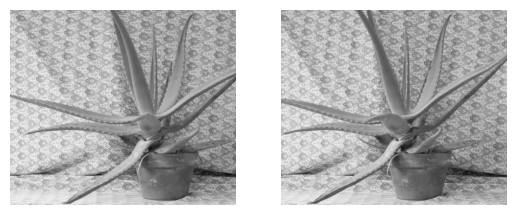

In [5]:
plt.figure()

plt.subplot(121)
plt.imshow(LeftImg, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(RightImg, cmap='gray')
plt.axis('off')

plt.show()

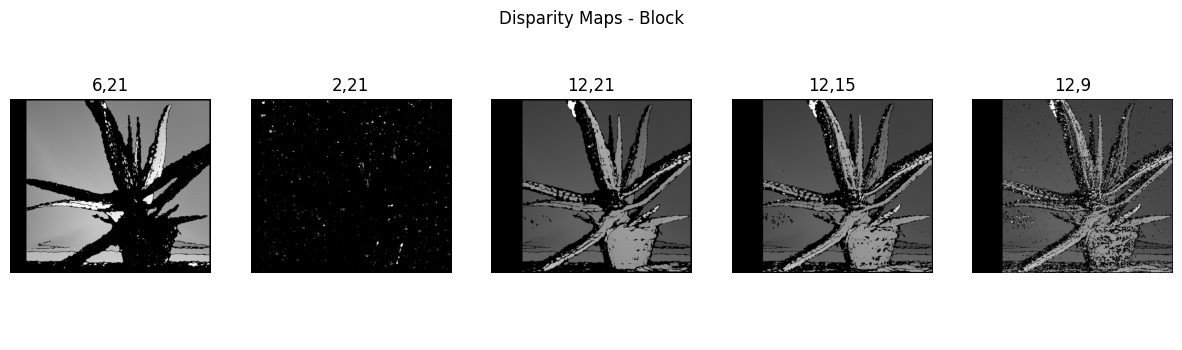

In [6]:
disp1 = depthBM(LeftImg, RightImg)
disp2 = depthBM(LeftImg, RightImg, 2)
disp3 = depthBM(LeftImg, RightImg, 12)

disp4 = depthBM(LeftImg, RightImg, 12, 15)
disp5 = depthBM(LeftImg, RightImg, 12, 9)


plt.figure(figsize=(15,4))
plt.title('Disparity Maps - Block')
plt.axis('off')

plt.subplot(151)
plt.imshow(disp1, cmap='gray')
plt.title('6,21')
plt.axis('off')

plt.subplot(152)
plt.imshow(disp2, cmap='gray')
plt.title('2,21')
plt.axis('off')

plt.subplot(153)
plt.imshow(disp3, cmap='gray')
plt.title('12,21')
plt.axis('off')


plt.subplot(154)
plt.imshow(disp4, cmap='gray')
plt.title('12,15')
plt.axis('off')

plt.subplot(155)
plt.imshow(disp5, cmap='gray')
plt.title('12,9')
plt.axis('off')

plt.show()

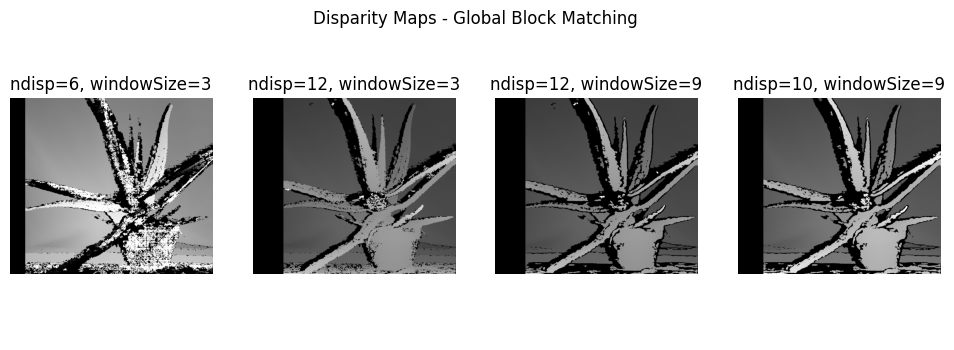

In [7]:
disp = depthSGBM(LeftImg, RightImg)
disp2 = depthSGBM(LeftImg, RightImg, ndisp=12, windowSize=3)
disp3 = depthSGBM(LeftImg, RightImg, ndisp=12, windowSize=9)
disp4 = depthSGBM(LeftImg, RightImg, ndisp=10, windowSize=9)

plt.figure(figsize=(12,4))
plt.title('Disparity Maps - Global Block Matching')
plt.axis('off')

plt.subplot(141)
plt.imshow(disp, cmap='gray')
plt.title('ndisp=6, windowSize=3')
plt.axis('off')

plt.subplot(142)
plt.imshow(disp2, cmap='gray')
plt.title('ndisp=12, windowSize=3')
plt.axis('off')

plt.subplot(143)
plt.imshow(disp3, cmap='gray')
plt.title('ndisp=12, windowSize=9')
plt.axis('off')

plt.subplot(144)
plt.imshow(disp4, cmap='gray')
plt.title('ndisp=10, windowSize=9')
plt.axis('off')


plt.show()

In [8]:
disparity = disp4

h, w = disparity.shape[:2]
focal_length = 0.8 * w  
Q = np.float32([
    [1, 0, 0, -0.5*w],
    [0,-1, 0,  0.5*h],
    [0, 0, 0, -focal_length],
    [0, 0, 1, 0]
])


In [9]:
points_3D = cv.reprojectImageTo3D(disparity, Q)
mask = disparity > disparity.min()
points = points_3D[mask]
colors = cv.cvtColor(LeftImg, cv.COLOR_BGR2RGB)[mask] 


In [10]:
def write_ply(filename, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')

write_ply('point_cloud.ply', points, colors)
print("point cloud saved as point_cloud.ply")


point cloud saved as point_cloud.ply


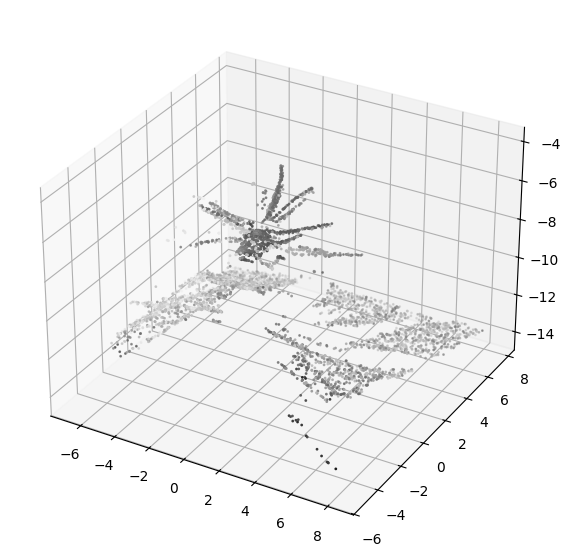

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sample = np.random.choice(points.shape[0], size=5000, replace=False)
ax.scatter(points[sample,0], points[sample,1], points[sample,2],
           c=colors[sample]/255.0, s=1)
plt.show()
